Target image: img_000845.jpg


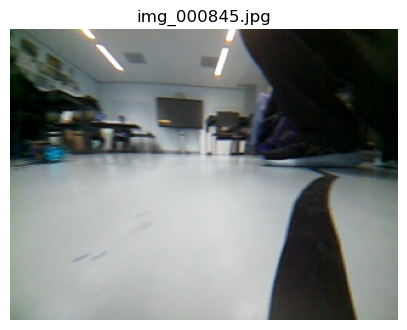

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = "/home/s25076817/notebooks/data/all_sessions_raw"

img_num = 845  # <-- change this if you want another
fname = f"img_{img_num:06d}.jpg"
fpath = os.path.join(img_dir, fname)

print("Target image:", fname)
if not os.path.exists(fpath):
    print("ERROR: file does not exist:", fpath)
else:
    img = Image.open(fpath).convert("RGB")
    plt.figure(figsize=(5, 4))
    plt.imshow(img)
    plt.title(fname)
    plt.axis("off")
    plt.show()


Session folder: /home/s25076817/notebooks/data/all_sessions_raw
Total images found: 3948
Found existing manual labels for 3728 images in /home/s25076817/notebooks/data/all_sessions_raw/all_sessions_labels_v2.csv
[WARN] No tape detected automatically in img_000002.jpg.


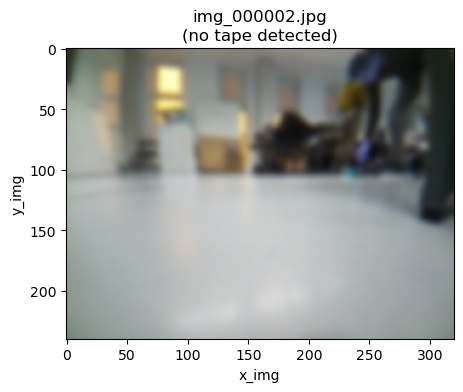

Image: img_000002.jpg
Suggested angle (deg vs vertical, bottom-origin): None


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped

[WARN] No tape detected automatically in img_000003.jpg.


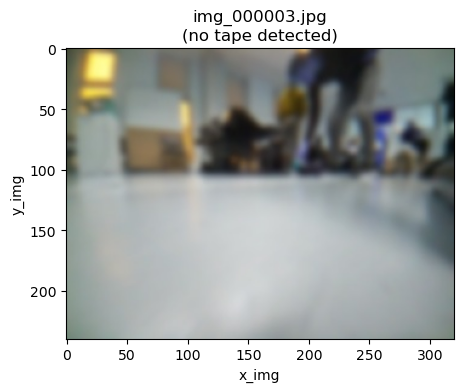

Image: img_000003.jpg
Suggested angle (deg vs vertical, bottom-origin): None


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped

[WARN] No tape detected automatically in img_000004.jpg.


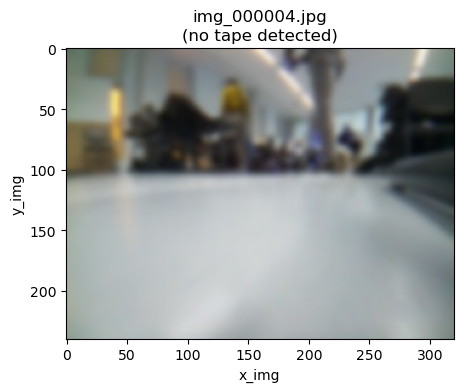

Image: img_000004.jpg
Suggested angle (deg vs vertical, bottom-origin): None


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped

[WARN] No tape detected automatically in img_000005.jpg.


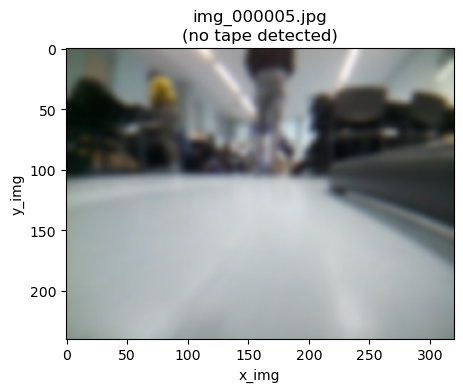

Image: img_000005.jpg
Suggested angle (deg vs vertical, bottom-origin): None


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped



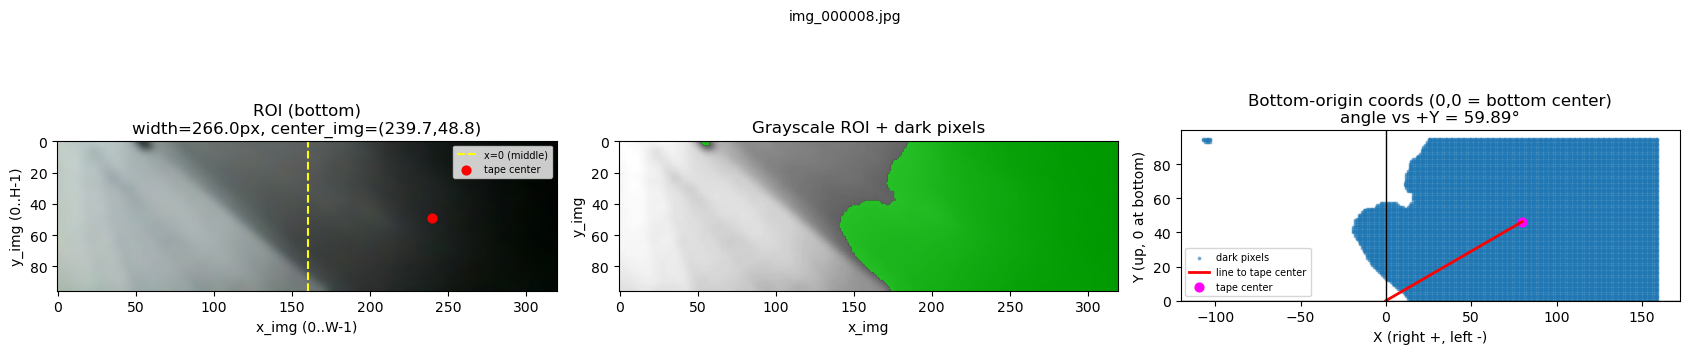

Image: img_000008.jpg
Suggested angle (deg vs vertical, bottom-origin): 59.89148579840852


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped



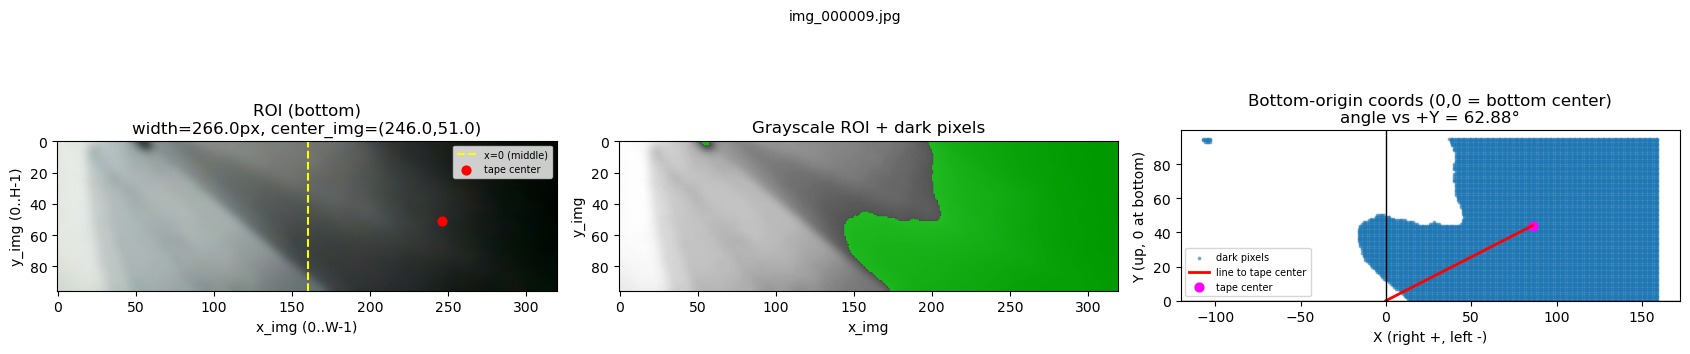

Image: img_000009.jpg
Suggested angle (deg vs vertical, bottom-origin): 62.88367637579162


Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg):  s


 -> skipped



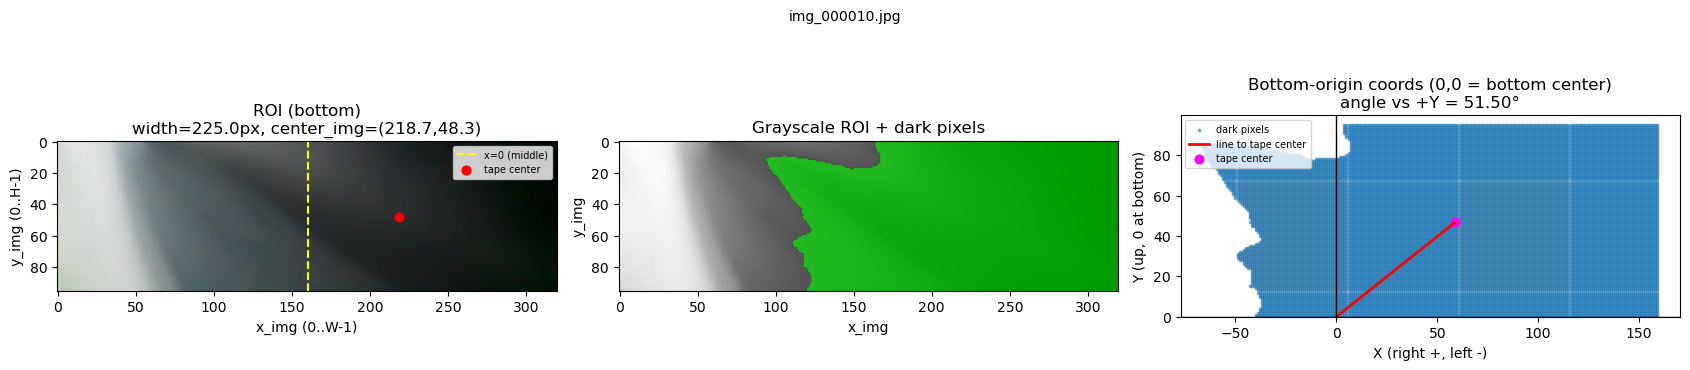

Image: img_000010.jpg
Suggested angle (deg vs vertical, bottom-origin): 51.49580726066441


In [ ]:
import os, glob, csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------- CONFIG -------------s

# base folder on GPU
DATA_ROOT = "/home/s25076817/notebooks/data"

# name of the folder that contains ALL merged images
SESSION   = "all_sessions_raw"         # <-- your big dataset folder

ROI_Y_MIN = 0.6        # bottom 40% of the image
ROI_Y_MAX = 1.0

THRESH_VALUE    = 80   # threshold for dark pixels (tape)
MIN_LINE_PIXELS = 200  # minimum pixels to trust the tape detection

# CSV file that will be created INSIDE all_sessions_raw
OUT_CSV         = "all_sessions_labels_v2.csv"

# ----------------------------------


def compute_tape_features(img_bgr):
    """
    Coordinate system in ROI:

        X: 0 at center,  X>0 to the RIGHT,  X<0 to the LEFT
        Y: 0 at BOTTOM, Y>0 going UP

    Tape center:
        mean of all dark pixels (mask == True).

    Angle definition (regression target):
        0°  = tape straight ahead (along +Y, upwards)
        >0° = tape center to the RIGHT
        <0° = tape center to the LEFT
    """
    h, w, _ = img_bgr.shape

    # 1) CROP ROI (bottom part)
    y1 = int(h * ROI_Y_MIN)
    y2 = int(h * ROI_Y_MAX)
    roi_bgr = img_bgr[y1:y2, :]
    roi_rgb = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2RGB)

    H, W, _ = roi_bgr.shape
    cx0 = W / 2.0   # image center x (for X=0)

    # 2) GRAYSCALE
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    gray_vis = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    # 3) DARK PIXEL MASK (tape = dark)
    mask = gray < THRESH_VALUE
    ys, xs = np.where(mask)  # image coords: x right, y down (0 at top of ROI)

    if len(xs) < MIN_LINE_PIXELS:
        return None

    tape_width = xs.max() - xs.min()

    # tape center in IMAGE coords
    center_x_img = xs.mean()
    center_y_img = ys.mean()

    # ---- bottom-origin coords ----
    # we want: X=0 center, Y=0 bottom
    def to_bottom_coords(x_img, y_img):
        X = x_img - cx0          # center x at 0
        Y = (H - 1) - y_img      # bottom at 0, up positive
        return X, Y

    # all tape pixels in bottom-origin coords (for scatter)
    Xs_b, Ys_b = to_bottom_coords(xs, ys)

    # tape center in bottom-origin coords
    Xc, Yc = to_bottom_coords(center_x_img, center_y_img)

    # direction vector from bottom center (0,0) to tape center
    dX = Xc
    dY = Yc

    # angle vs +Y axis:
    # atan2(dX, dY):  dX>0 => right (positive), dX<0 => left (negative)
    angle_rad = np.arctan2(dX, dY)
    angle_deg = float(np.degrees(angle_rad))

    # line for visualization: from (0,0) to (Xc, Yc)
    X_line_b = np.array([0.0, Xc])
    Y_line_b = np.array([0.0, Yc])

    feats = {
        "roi_rgb": roi_rgb,
        "gray_vis": gray_vis,
        "mask": mask,
        "xs": xs,
        "ys": ys,
        "Xs_b": Xs_b,
        "Ys_b": Ys_b,
        "tape_width": tape_width,
        "cx_img": center_x_img,
        "cy_img": center_y_img,
        "angle_deg": angle_deg,
        "X_line_b": X_line_b,
        "Y_line_b": Y_line_b,
        "roi_height": H,
        "roi_width": W,
        "cx0": cx0,
        "Xc": Xc,
        "Yc": Yc,
    }
    return feats


def load_existing_manual(out_path):
    existing = set()
    if os.path.isfile(out_path):
        with open(out_path, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                existing.add(row["filename"])
        print(f"Found existing manual labels for {len(existing)} images in {out_path}")
    else:
        print("No existing manual label CSV found, starting fresh.")
    return existing


def visualize_features(fname, feats):
    roi_rgb   = feats["roi_rgb"]
    gray_vis  = feats["gray_vis"]
    mask      = feats["mask"]
    xs        = feats["xs"]
    ys        = feats["ys"]
    Xs_b      = feats["Xs_b"]
    Ys_b      = feats["Ys_b"]
    tape_w    = feats["tape_width"]
    cx_img    = feats["cx_img"]
    cy_img    = feats["cy_img"]
    angle_deg = feats["angle_deg"]
    X_line_b  = feats["X_line_b"]
    Y_line_b  = feats["Y_line_b"]
    H         = feats["roi_height"]
    W         = feats["roi_width"]
    cx0       = feats["cx0"]
    Xc        = feats["Xc"]
    Yc        = feats["Yc"]

    fig, axes = plt.subplots(1, 3, figsize=(17, 4))

    # Panel 1
    ax = axes[0]
    ax.imshow(roi_rgb)
    ax.set_title(
        f"ROI (bottom)\nwidth={tape_w:.1f}px, center_img=({cx_img:.1f},{cy_img:.1f})"
    )
    ax.axvline(cx0, color="yellow", linestyle="--", label="x=0 (middle)")
    ax.scatter([cx_img], [cy_img], c="red", s=40, label="tape center")
    ax.set_xlabel("x_img (0..W-1)")
    ax.set_ylabel("y_img (0..H-1)")
    ax.legend(fontsize=7, loc="best")

    # Panel 2
    ax = axes[1]
    ax.set_title("Grayscale ROI + dark pixels")
    ax.imshow(gray_vis, cmap="gray")
    mask_vis = np.zeros((*mask.shape, 4), dtype=np.float32)
    mask_vis[mask] = [0, 1, 0, 0.6]  # green overlay
    ax.imshow(mask_vis)
    ax.set_xlabel("x_img")
    ax.set_ylabel("y_img")

    # Panel 3
    ax = axes[2]
    ax.set_title(
        f"Bottom-origin coords (0,0 = bottom center)\nangle vs +Y = {angle_deg:.2f}°"
    )
    ax.scatter(Xs_b, Ys_b, s=3, alpha=0.5, label="dark pixels")
    ax.plot(X_line_b, Y_line_b, "r", linewidth=2, label="line to tape center")
    ax.scatter([Xc], [Yc], c="magenta", s=40, label="tape center")

    ax.axhline(0, color="black", linewidth=1)
    ax.axvline(0, color="black", linewidth=1)

    ax.set_xlabel("X (right +, left -)")
    ax.set_ylabel("Y (up, 0 at bottom)")
    ax.legend(fontsize=7, loc="best")
    ax.set_aspect("equal", "box")
    ax.set_ylim(bottom=0)

    plt.suptitle(fname, fontsize=10)
    plt.tight_layout()
    plt.show()


def manual_label_session():
    session_dir = os.path.join(DATA_ROOT, SESSION)
    out_path    = os.path.join(session_dir, OUT_CSV)

    img_paths = sorted(glob.glob(os.path.join(session_dir, "img_*.jpg")))
    print("Session folder:", session_dir)
    print("Total images found:", len(img_paths))

    already = load_existing_manual(out_path)

    file_exists = os.path.isfile(out_path)
    f = open(out_path, "a", newline="")
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(["filename", "angle_deg"])

    try:
        for img_path in img_paths:
            fname = os.path.basename(img_path)

            if fname in already:
                continue

            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                print("[SKIP] could not read:", img_path)
                continue

            feats = compute_tape_features(img_bgr)
            if feats is None:
                print(f"[WARN] No tape detected automatically in {fname}.")
                suggested = None
            else:
                suggested = feats["angle_deg"]

            if feats is not None:
                visualize_features(fname, feats)
            else:
                plt.figure(figsize=(5, 4))
                plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
                plt.title(fname + "\n(no tape detected)")
                plt.xlabel("x_img")
                plt.ylabel("y_img")
                plt.show()

            print(f"Image: {fname}")
            print(f"Suggested angle (deg vs vertical, bottom-origin): {suggested}")
            user = input(
                "Press ENTER to ACCEPT, 's' to SKIP, or type your own angle (deg): "
            ).strip()

            if user.lower() == "s":
                print(" -> skipped\n")
                continue

            if user == "":
                if suggested is None:
                    user2 = input(
                        "No suggestion. Type angle in degrees (or 's' to skip): "
                    ).strip()
                    if user2.lower() == "s" or user2 == "":
                        print(" -> skipped\n")
                        continue
                    try:
                        angle = float(user2)
                    except ValueError:
                        print("Invalid input, skipping.\n")
                        continue
                else:
                    angle = float(suggested)
                    print(f" -> accepted suggestion: {angle:.2f}\n")
            else:
                try:
                    angle = float(user)
                    print(f" -> manual label set to: {angle:.2f}\n")
                except ValueError:
                    print("Invalid input, skipping.\n")
                    continue

            writer.writerow([fname, angle])
            f.flush()

    finally:
        f.close()
        print("Manual labeling finished. CSV saved at:", out_path)


# -------- RUN TOOL --------
manual_label_session()
